In [2]:
# Some new libraries: they should already
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString

# A new library to install in your environment
# conda install -c conda-forge spaghetti (if using conda)
!pip install spaghetti
import spaghetti

# Our usual libraries
import os
import glob

import pandas as pd
import networkx
!pip install osmnx
import osmnx
from helpers.location_converter import ENtoLL84

from matplotlib import pyplot as plt
import esda
import seaborn as sns

/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


/tmp/ipykernel_4800/1702422276.py:4: FutureWarning: The buffer_dist argument has been deprecated and will be removed in the v2.0.0 release. Buffer your results directly, if desired.
  leeds_area = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=10)


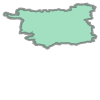

In [9]:
# Choose a place whose crimes we will analyse with respect to its street network
PLACE_OF_INTEREST = "Leeds, United Kingdom"
# Get the geographical area of Soho from OpenStreetMap as a GeoDataFrame
leeds_area = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=10)
# From this take the polygon that defines Soho's boundary
leeds_polygon = leeds_area['geometry'][0]
leeds_polygon

In [10]:
df2014 = pd.read_csv('../data/clean_2014.csv')
df2015 = pd.read_csv('../data/clean_2015.csv')
df2016 = pd.read_csv('../data/clean_2016.csv')
df2017 = pd.read_csv('../data/clean_2017.csv')
df2018 = pd.read_csv('../data/clean_2018.csv')
df2019 = pd.read_csv('../data/clean_2019.csv')

all_datasets = [df2014, df2015, df2016, df2017, df2018, df2019]

concat_data = pd.concat(all_datasets)

concat_data[['longitude', 'latitude']] = concat_data.apply(lambda row: pd.Series(ENtoLL84(row['Grid Ref: Easting'], row['Grid Ref: Northing'])), axis=1)

concat_data.to_csv('concat_data.csv')

/home/john_kelly_tamargo/NDA/NDACW2/taskB/helpers/location_converter.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return transform(v36, v84, vlon36, vlat36) # (longitude, latitude)


In [11]:
# Some crimes do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents = concat_data.dropna(subset=['longitude', 'latitude'])
print("Total no. of located accidents filtered: {}".format(len(located_accidents)))

Total no. of located accidents filtered: 10550


In [12]:
# XXX Run this cell to process  network pattern analysis
located_accidents = located_accidents.sample(frac=.3)
len(located_accidents)  # to double-check

3165

In [13]:
# Translate to a GeoDataFrame where the geometry is given by a Point constructed from the longitude and latitude
accident_points = GeoDataFrame(geometry=[Point(xy) for xy in zip(
    located_accidents.longitude, located_accidents.latitude)])

print("Total no. of located accidents filtered: {}".format(len(accident_points)))

accident_points

Total no. of located accidents filtered: 3165


,geometry
0,POINT (-1.52371 53.81775)
1,POINT (-1.61027 53.84412)
2,POINT (-1.53989 53.79866)
3,POINT (-1.59366 53.83806)
4,POINT (-1.53263 53.80429)
...,...
3160,POINT (-1.64056 53.83777)
3161,POINT (-1.52615 53.90692)
3162,POINT (-1.56932 53.80534)
3163,POINT (-1.48105 53.82835)


In [14]:
leeds_accidents = accident_points[accident_points.geometry.within(leeds_polygon)]
leeds_accidents

,geometry
0,POINT (-1.52371 53.81775)
1,POINT (-1.61027 53.84412)
2,POINT (-1.53989 53.79866)
3,POINT (-1.59366 53.83806)
4,POINT (-1.53263 53.80429)
...,...
3160,POINT (-1.64056 53.83777)
3161,POINT (-1.52615 53.90692)
3162,POINT (-1.56932 53.80534)
3163,POINT (-1.48105 53.82835)


In [15]:
# Get the network of streets in Soho
leeds_graph = osmnx.graph_from_place(PLACE_OF_INTEREST)

In [16]:
# We can see that the nodes are specified by x, y, coordinates
list(leeds_graph.nodes(data=True))[0:10]

[(154962,
  {'y': 53.844618,
   'x': -1.34293,
   'ref': '44',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (155002, {'y': 53.7617259, 'x': -1.4990779, 'street_count': 3}),
 (155014,
  {'y': 53.7499667,
   'x': -1.517335,
   'ref': '43',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (155023,
  {'y': 53.7416937,
   'x': -1.514124,
   'ref': '42',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (155035,
  {'y': 53.7256632,
   'x': -1.516511,
   'ref': '42',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (319339,
  {'y': 53.7618899,
   'x': -1.4990993,
   'ref': '44',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (319387,
  {'y': 53.7722835,
   'x': -1.4777674,
   'ref': '45',
   'highway': 'motorway_junction',
   'street_count': 3}),
 (319415, {'y': 53.7728145, 'x': -1.4767924, 'street_count': 3}),
 (319568, {'y': 53.7997084, 'x': -1.4146292, 'street_count': 3}),
 (319577,
  {'y': 53.7995475,
   'x': -1.4144888,
   'ref'

In [17]:
list(leeds_graph.edges(data=True))[0:3]

[(154962,
  3504720,
  {'osmid': [1205657262, 3998255],
   'oneway': True,
   'lanes': '2',
   'highway': 'motorway_link',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 549.2520000000001,
   'geometry': <LINESTRING (-1.343 53.845, -1.344 53.846, -1.344 53.847, -1.344 53.848, -1....>}),
 (154962,
  30804402,
  {'osmid': [329022404, 10416772, 329022405, 143902500],
   'oneway': True,
   'lanes': '3',
   'ref': 'A1(M)',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 1868.7210000000002,
   'bridge': 'yes',
   'geometry': <LINESTRING (-1.343 53.845, -1.343 53.847, -1.343 53.848, -1.343 53.848, -1....>}),
 (155002,
  1596671811,
  {'osmid': 91015599,
   'oneway': True,
   'lanes': '3',
   'ref': 'M1',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 1637.7389999999998,
   'geometry': <LINESTRING (-1.499 53.762, -1.501 53.762, -1.501 53.762, -1.502 53.761, -1....>})]

In [18]:
x_values = networkx.get_node_attributes(leeds_graph, 'x')
y_values = networkx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

[(154962,
  3504720,
  {'osmid': [1205657262, 3998255],
   'oneway': True,
   'lanes': '2',
   'highway': 'motorway_link',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 549.2520000000001,
   'geometry': <LINESTRING (-1.343 53.845, -1.344 53.846, -1.344 53.847, -1.344 53.848, -1....>}),
 (154962,
  30804402,
  {'osmid': [329022404, 10416772, 329022405, 143902500],
   'oneway': True,
   'lanes': '3',
   'ref': 'A1(M)',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 1868.7210000000002,
   'bridge': 'yes',
   'geometry': <LINESTRING (-1.343 53.845, -1.343 53.847, -1.343 53.848, -1.343 53.848, -1....>}),
 (155002,
  1596671811,
  {'osmid': 91015599,
   'oneway': True,
   'lanes': '3',
   'ref': 'M1',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'reversed': False,
   'length': 1637.7389999999998,
   'geometry': <LINESTRING (-1.499 53.762, -1.501 53.762, -1.501 53.762, -1.502 53.761, -1....>}),
 (155014,
  319339,
  {'osmid': [1592

In [19]:
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

In [18]:
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

In [20]:
# We will now snap the Soho located crimes we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accidents, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/spaghetti/util.py:583: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


observation 1
true coords:	(-1.4033992168737162, 53.78676890310754)
snapped coords:	(-1.4033997431067615, 53.78677340481294)


<Axes: >

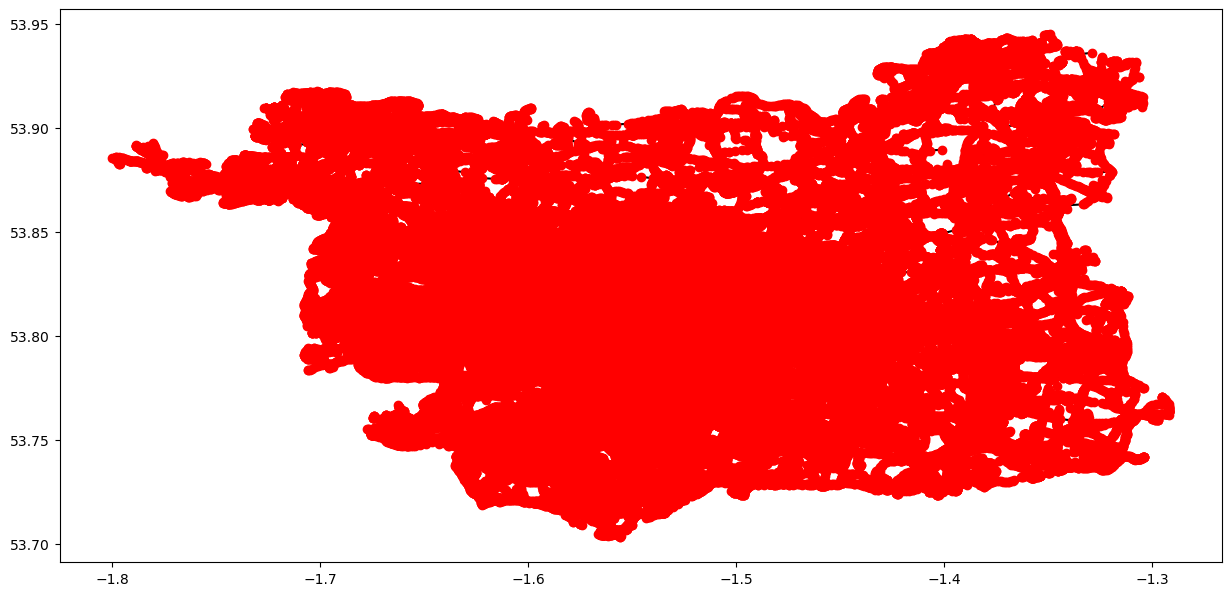

In [21]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

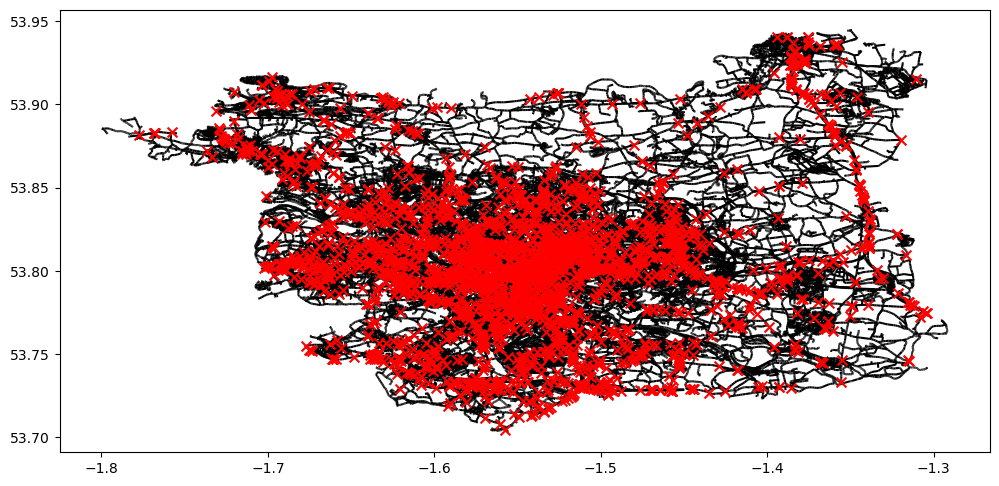

In [22]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_crimes=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='crimes', snapped=True)

# Plot these on the road network
snapped_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

<Axes: >

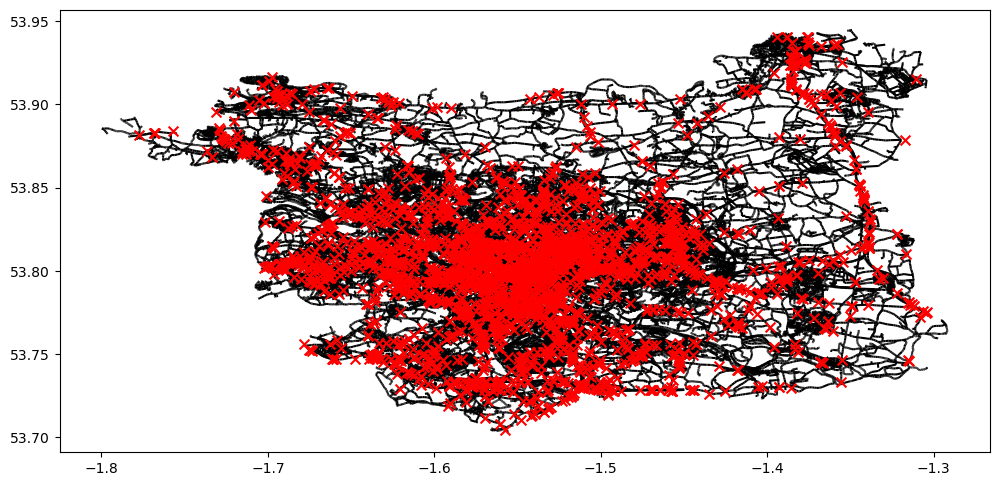

In [23]:
# Show the network unsnapped
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_crimes=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='crimes', snapped=False)

# Plot these on the road network
observed_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

# plt.savefig('crime_observations_unsnapped')

In [24]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["crimes"],
    nsteps=50, permutations=50
)

MemoryError: Unable to allocate 900. GiB for an array with shape (347530, 347530) and data type float64

In [ ]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

In [ ]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

In [1]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
# Get snapped point pattern
pointpat = leeds_points_graph.pointpatterns['crimes']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)
counts

In [ ]:
weights = leeds_points_graph.w_network
weights

In [ ]:
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [ ]:
moran = esda.moran.Moran(values, weights)
moran.I

In [ ]:
moran.p_sim

In [ ]:
moran.EI
moran.EI_sim

print(moran.EI)

In [ ]:
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")